======================================================
# **Deep Learning Course** - Fall 2021 -25647
======================================================

======================================================
### **Student Information:**
* Name= Mohammad
* Last Name= Fahim
* ID= 99206099

======================================================

# **Deep Crossentropy method**

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games.





In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week1_intro/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 4
n_actions = 2


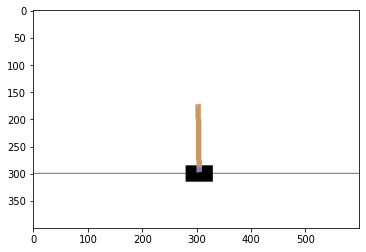

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [4]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(2,1,p=probs)[0]
      
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [5]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 9.5554581e-03  4.1174494e-02  2.9429482e-02 -2.8828064e-02]
 [ 1.0378948e-02 -1.5435687e-01  2.8852921e-02  2.7299300e-01]
 [ 7.2918111e-03 -3.4987837e-01  3.4312781e-02  5.7463479e-01]
 [ 2.9424363e-04 -5.4546416e-01  4.5805477e-02  8.7792671e-01]
 [-1.0615040e-02 -3.5099360e-01  6.3364007e-02  5.9998894e-01]]
actions: [0, 0, 0, 1, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM.

The only difference is that now each observation is not a number but a `float32` vector.

In [1]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    """
    reward_threshold = np.percentile(rewards_batch, percentile)

    buffer =  [states_batch[i] for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold] 
    elite_states = []
    for i in buffer:
        for j in i:
            elite_states.append(j.tolist())
   
    buffer =  [actions_batch[i] for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold] 
    elite_actions = []
    for i in buffer:
        for j in i:
            elite_actions.append(j.tolist())
       
    return np.array(elite_states,dtype=np.float32), np.array(elite_actions,dtype=np.float32)

# Training loop
Generate sessions, select N best and fit to those.

In [7]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [10]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [ generate_session(env, agent) for _ in range(n_sessions)] 

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent.fit(elite_states, elite_actions)

    # show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

/tmp/ipykernel_56204/1984003575.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
/tmp/ipykernel_56204/1984003575.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
/tmp/ipykernel_56204/1984003575.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

You Win! You may stop training now via KeyboardInterrupt.


# Results

In [12]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [11]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices